<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-3CLS/blob/No-Building/Kaggle_3CLS_No_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [2]:
!pip uninstall jax -y

Found existing installation: jax 0.4.26
Uninstalling jax-0.4.26:
  Successfully uninstalled jax-0.4.26


In [3]:
!pip install tensorflow==2.15.0

In [4]:
!python --version

Python 3.10.12


In [5]:
!pip install image_to_numpy==1.0.0

  Preparing metadata (setup.py) ... done
  Created wheel for image_to_numpy: filename=image_to_numpy-1.0.0-py3-none-any.whl size=3456 sha256=c3deb7b7914856f7d2710ced979b387ac13f4b723c9ee210a707cdf3e4a5fab3
  Stored in directory: /root/.cache/pip/wheels/4c/e5/7e/f10f47129bb75abc8cd52a8abbff926b4a6121990f926cfe6d
Successfully built image_to_numpy


In [6]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.5/495.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.5 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=1ed9cb848046d8e5c87262e0367bbfddcf91e0f85b25779ee0b25c5301fe7af3
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset'):
    print(os.path.join(dirname))




/content/drive/MyDrive/Chua_Thesis/4-600-Dataset
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Road
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Vehicle
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Plant
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Building


In [28]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=512,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))

    model.add(Dense(units=3, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=10,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [12]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [13]:
with tf.device('/gpu:0'):
    labels = ['Plant', 'Vehicle', 'Road']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [14]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [15]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

plants_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
total_test_idx = np.concatenate((plants_test_idx, vehicles_test_idx, roads_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [16]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [17]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [18]:
!mkdir MODEL

In [19]:
!ls ./

drive  MODEL  sample_data


In [30]:
model_name= 'Model 3CLS-NB-4.1.0'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-3Cls-No-Building'

[neptune] [info   ] Neptune initialized. Open in the app: offline/bc7c04e7-b262-4a50-a525-7ff41cca11b2
Epoch 1/45
158/158 [==============================] - ETA: 0s - loss: 11.8376 - accuracy: 0.7222
Epoch 1: val_loss improved from inf to 3.25897, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-0
158/158 [==============================] - 14s 55ms/step - loss: 11.8376 - accuracy: 0.7222 - val_loss: 3.2590 - val_accuracy: 0.4833 - lr: 0.0020
Epoch 2/45
157/158 [============================>.] - ETA: 0s - loss: 1.3552 - accuracy: 0.7946
Epoch 2: val_loss improved from 3.25897 to 1.16063, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-0
158/158 [==============================] - 8s 52ms/step - loss: 1.3520 - accuracy: 0.7944 - val_loss: 1.1606 - val_accuracy: 0.6778 - lr: 0.0020
Epoch 3/45
157/158 [============================>.] - ETA: 0s - loss: 0.7925 - accuracy: 0.8360
Epoch 3: val_loss improved from 1.16063 to 0.40607, saving model to /content/MODEL/Model 3CLS-NB-4.1

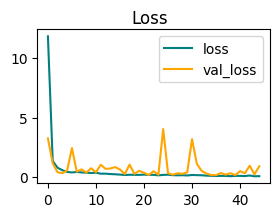

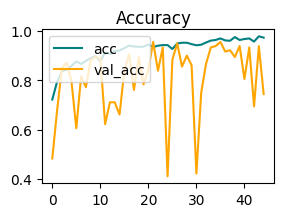

Fold Training Time: 0 hour(s) and 3 mins
Precision: 95.50561904907227  -  Recall: 94.44444179534912
Accuracy: 95.55555582046509
F1Score-P: 95.08197021484375
F1Score-R: 97.4358901977539
F1Score-V: 94.21487426757812
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/d9884999-22de-4627-b99b-f16f6b62490c
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 12.7695 - accuracy: 0.7070
Epoch 1: val_loss improved from inf to 21.20740, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-1
158/158 [==============================] - 14s 59ms/step - loss: 12.7449 - accuracy: 0.7071 - val_loss: 21.2074 - val_accuracy: 0.3333 - lr: 0.0020
Epoch 2/45
156/158 [============================>.] - ETA: 0s - loss: 1.2915 - accuracy: 0.8069
Epoch 2: val_loss improved from 21.20740 to 3.42387, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-1
158/158 [==============

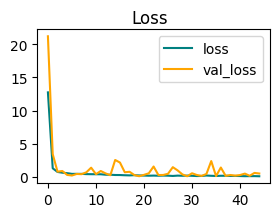

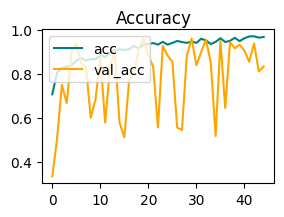

Fold Training Time: 0 hour(s) and 3 mins
Precision: 96.64804339408875  -  Recall: 96.11111283302307
Accuracy: 96.11111283302307
F1Score-P: 95.93496704101562
F1Score-R: 95.72649383544922
F1Score-V: 96.66666412353516
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/7340586a-394c-4618-89da-411bba81b2a9
Epoch 1/45
158/158 [==============================] - ETA: 0s - loss: 13.5278 - accuracy: 0.7214
Epoch 1: val_loss improved from inf to 17.86162, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-2
158/158 [==============================] - 11s 52ms/step - loss: 13.5278 - accuracy: 0.7214 - val_loss: 17.8616 - val_accuracy: 0.3611 - lr: 0.0020
Epoch 2/45
155/158 [============================>.] - ETA: 0s - loss: 1.3078 - accuracy: 0.7839
Epoch 2: val_loss improved from 17.86162 to 4.16378, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-2
158/158 [=============

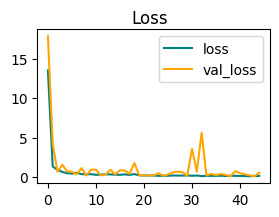

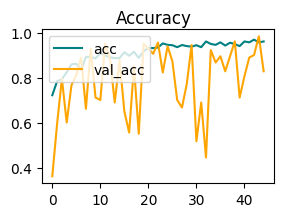

Fold Training Time: 0 hour(s) and 3 mins
Precision: 98.33333492279053  -  Recall: 98.33333492279053
Accuracy: 98.33333492279053
F1Score-P: 98.30508422851562
F1Score-R: 98.33333587646484
F1Score-V: 98.36064910888672
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/f8d26cfc-c2e9-4499-85ea-60be743682fc
Epoch 1/45
156/158 [============================>.] - ETA: 0s - loss: 11.6738 - accuracy: 0.6915
Epoch 1: val_loss improved from inf to 1.78352, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-3
158/158 [==============================] - 13s 61ms/step - loss: 11.5689 - accuracy: 0.6937 - val_loss: 1.7835 - val_accuracy: 0.4333 - lr: 0.0020
Epoch 2/45
156/158 [============================>.] - ETA: 0s - loss: 0.8304 - accuracy: 0.8165
Epoch 2: val_loss improved from 1.78352 to 1.19061, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-3
158/158 [================

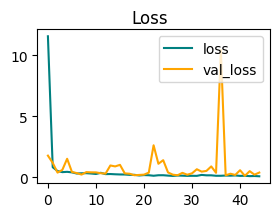

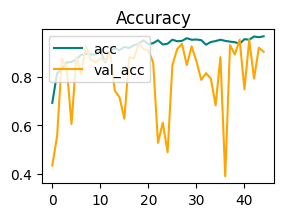

Fold Training Time: 0 hour(s) and 3 mins
Precision: 97.14285731315613  -  Recall: 94.44444179534912
Accuracy: 95.55555582046509
F1Score-P: 94.30894470214844
F1Score-R: 95.65217590332031
F1Score-V: 96.72130584716797
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/89e5e67c-286c-4577-96db-e957200be752
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 13.9258 - accuracy: 0.6688
Epoch 1: val_loss improved from inf to 2.39003, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-4
158/158 [==============================] - 17s 90ms/step - loss: 13.8843 - accuracy: 0.6690 - val_loss: 2.3900 - val_accuracy: 0.4722 - lr: 0.0020
Epoch 2/45
156/158 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.7724
Epoch 2: val_loss improved from 2.39003 to 2.13400, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-4
158/158 [================

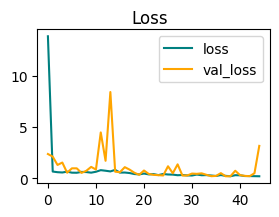

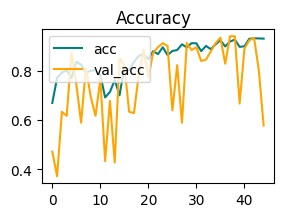

Fold Training Time: 0 hour(s) and 5 mins
Precision: 94.91525292396545  -  Recall: 93.33333373069763
Accuracy: 93.88889074325562
F1Score-P: 92.43697357177734
F1Score-R: 92.30768585205078
F1Score-V: 96.7741928100586
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/436ee8e7-1c46-4f9c-8506-0e8337d75b08
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 14.2589 - accuracy: 0.7054
Epoch 1: val_loss improved from inf to 3.83303, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-5
158/158 [==============================] - 15s 69ms/step - loss: 14.2254 - accuracy: 0.7048 - val_loss: 3.8330 - val_accuracy: 0.6111 - lr: 0.0020
Epoch 2/45
156/158 [============================>.] - ETA: 0s - loss: 0.9746 - accuracy: 0.7901
Epoch 2: val_loss improved from 3.83303 to 3.53227, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-5
158/158 [=================

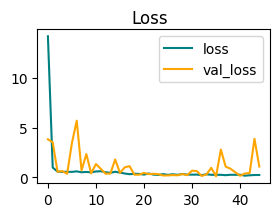

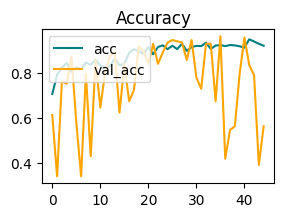

Fold Training Time: 0 hour(s) and 3 mins
Precision: 98.29545617103577  -  Recall: 96.11111283302307
Accuracy: 96.11111283302307
F1Score-P: 97.47898864746094
F1Score-R: 94.21487426757812
F1Score-V: 96.66666412353516
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/8ffd79d8-9058-40e0-8d5f-df0ae9469fdc
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 15.1871 - accuracy: 0.6537
Epoch 1: val_loss improved from inf to 12.56631, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-6
158/158 [==============================] - 12s 57ms/step - loss: 15.1452 - accuracy: 0.6532 - val_loss: 12.5663 - val_accuracy: 0.3333 - lr: 0.0020
Epoch 2/45
157/158 [============================>.] - ETA: 0s - loss: 0.8405 - accuracy: 0.8097
Epoch 2: val_loss improved from 12.56631 to 5.11749, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-6
158/158 [=============

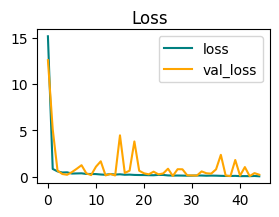

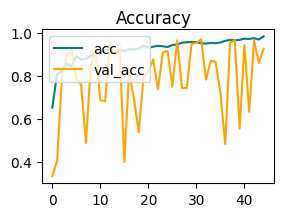

Fold Training Time: 0 hour(s) and 4 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-P: 96.55171966552734
F1Score-R: 96.72130584716797
F1Score-V: 96.72130584716797
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/a71cc9b8-5d77-4b1f-9ad1-1adee6042deb
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 13.3258 - accuracy: 0.6823
Epoch 1: val_loss improved from inf to 2.31093, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-7
158/158 [==============================] - 13s 54ms/step - loss: 13.2875 - accuracy: 0.6817 - val_loss: 2.3109 - val_accuracy: 0.3333 - lr: 0.0020
Epoch 2/45
156/158 [============================>.] - ETA: 0s - loss: 0.8609 - accuracy: 0.7973
Epoch 2: val_loss improved from 2.31093 to 1.41310, saving model to /content/MODEL/Model 3CLS-NB-4.1.0/FOLD-7
158/158 [================

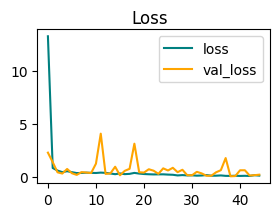

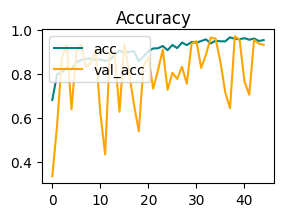

Fold Training Time: 0 hour(s) and 4 mins
Precision: 97.20670580863953  -  Recall: 96.66666388511658
Accuracy: 97.22222089767456
F1Score-P: 95.86776733398438
F1Score-R: 96.61016845703125
F1Score-V: 99.17355346679688
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 0 hour(s) and 34 mins


In [31]:
params = {
    "lr": 0.002,
    "epochs": 45,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_plant = []
f1_road = []
f1_vcl = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_plant.append(f1_s[0])
        f1_vcl.append(f1_s[1])
        f1_road.append(f1_s[2])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-P"] = f1_plant[counter]
        run["eval/F1-R"] = f1_road[counter]
        run["eval/F1-V"] = f1_vcl[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-P: {f1_plant[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')
        print(f'F1Score-V: {f1_vcl[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [32]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-P: {avg_rate(f1_plant)}
Avg F1-Score-R: {avg_rate(f1_road)}
Avg F1-Score-V: {avg_rate(f1_vcl)}
""")


Avg Accuracy: 96.1805559694767
Avg Precision: 96.83924168348312
Avg Recall: 95.76388821005821
Avg F1-Score-P: 95.74580192565918
Avg F1-Score-R: 95.87524127960205
Avg F1-Score-V: 96.91240119934082



In [33]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-P"] = avg_rate(f1_plant)
run["eval/F1-R"] = avg_rate(f1_road)
run["eval/F1-V"] = avg_rate(f1_vcl)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/3c981187-12d7-4953-a1fd-550f0d514ed1
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [34]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [35]:
!neptune sync -p 'New-Thesis/Kaggle-3Cls-No-Building' --offline-only


Offline container 9bd59829-b494-4f9e-8f4c-37ee88e33fd1 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-16
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-16
Deleted: /content/.neptune/async/run__9bd59829-b494-4f9e-8f4c-37ee88e33fd1__30687__q0kc9cap
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-16 completed.
Offline container 9bd59842-92c7-4e1d-9828-fef60e1ea53b registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-17
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-17
Deleted: /content/.neptune/async/run__9bd59842-92c7-4e1d-9828-fef60e1ea53b__30687__qa01npuu
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-17 completed.
Offline container 9bd59852-7495-4463-82fa-e525ac79b13e registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-18
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-18
Deleted: /content/.neptune/async/run__9bd59852-7495-4463-82fa-e525ac79b13e__30687__4kpf4x9g
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-

In [36]:
!neptune clear


In [37]:
!rm -r "/content/MODEL/Model 3CLS-NB-4.1.0"

## Extract Model Checkpoint
- Download model from neptune AI
- Upload here
- change path and names and run code

In [ ]:
sm = tf.keras.models.load_model("/content/model.keras")


In [ ]:
FIX-MODEL-NAME

sm.save_weights("./checkpoints/test_model")


In [ ]:
!zip -r test.zip "./checkpoints"